In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
pop_dict = json.load(open('../isolate_and_pop_info/pop_dict.json'))
for strain, pops in pop_dict.items():
    pop_dict[strain] = pops
    
strains = list(pop_dict.keys())

In [4]:
cnv_files = !ls FREEC_output_250bp_window/*_CNVs

df = pd.DataFrame()

for i, f in enumerate(cnv_files):
    
    strain = f.replace('.CpSilv_core_only_bwa.sorted.bam_CNVs', '').replace('FREEC_output_250bp_window/','')
    
    if strain not in strains:
        continue
        
    temp = pd.read_csv(f, sep='\t', header=None,)
    temp.columns=['chrom', 'start','stop', 'CN', 'type']
    temp['strain'] = [strain for s in range(temp.shape[0])]

    df = pd.concat([df, temp])

In [5]:
df.sort_values('start')

,chrom,start,stop,CN,type,strain
189,CP075072.1,0,64750,0,loss,Nuevo_Leon_1
0,CP075068.1,0,8500,2,gain,San_Antonio_1
58,CP075069.1,0,66500,0,loss,B5773_Brazil
154,CP075072.1,250,7500,0,loss,Tucson_13
117,CP075071.1,250,3500,0,loss,Tucson_13
...,...,...,...,...,...,...
58,CP075068.1,8327250,8334250,2,gain,2566_Venezuela
51,CP075068.1,8327250,8334250,2,gain,JTORRES_Venezuela
48,CP075068.1,8327250,8334250,2,gain,3796_Venezuela
66,CP075068.1,8327250,8334250,2,gain,4545-MICE_Venezuela


In [11]:
repeatmasker_path = '../ref/RepeatMasker/CpSilv_core_only.fasta.out.gff'
repeatmasker = pd.read_csv(repeatmasker_path, sep='\t', header=None, comment='#')[[0,2,3,4,6,8]]
repeatmasker.columns = ['chrom', 'type', 'start', 'stop', 'direction', 'annotation']

nuc_repeats = repeatmasker[(repeatmasker['annotation'].str.contains(r'\([A-Z]+\)')) | (repeatmasker['annotation'].str.contains('-rich'))]
transposons = repeatmasker[~repeatmasker.index.isin(nuc_repeats.index)]

transposons['midpoint'] = transposons['start']+(transposons['stop']-transposons['start'])/2
transposons

<ipython-input-11-1527e77d5206>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transposons['midpoint'] = transposons['start']+(transposons['stop']-transposons['start'])/2


,chrom,type,start,stop,direction,annotation,midpoint
1,CP075068.1,similarity,116,292,-,"Target ""Motif:DTX-incomp-chim_Blc56_Cpos_C735-...",204.0
2,CP075068.1,similarity,157,1136,+,"Target ""Motif:RXX-TRIM_Blc207_Cpos_C735-L-B65-...",646.5
3,CP075068.1,similarity,993,1672,-,"Target ""Motif:DTX-incomp-chim_Blc56_Cpos_C735-...",1332.5
5,CP075068.1,similarity,1708,9391,-,"Target ""Motif:DTX-incomp-chim_Blc56_Cpos_C735-...",5549.5
6,CP075068.1,similarity,8471,16405,-,"Target ""Motif:DTX-incomp-chim_Blc41_Cpos_C735-...",12438.0
...,...,...,...,...,...,...,...
11265,CP075072.1,similarity,1463409,1464429,-,"Target ""Motif:DTX-incomp-chim_Blc73_Superconti...",1463919.0
11266,CP075072.1,similarity,1463830,1471523,-,"Target ""Motif:DTX-incomp_Blc54_Supercontig_3.5...",1467676.5
11267,CP075072.1,similarity,1470023,1472092,+,"Target ""Motif:RXX-LARD_Blc184_Cpos_C735-L-B59-...",1471057.5
11268,CP075072.1,similarity,1472093,1481680,+,"Target ""Motif:DTX-incomp-chim_Blc41_Cpos_C735-...",1476886.5


In [7]:
tx_distance = {}

for chrom in sorted(df['chrom'].unique()):
    
    temp_cnv = df[df['chrom']==chrom]
    temp_tx = transposons[transposons['chrom']==chrom]
    
    for tx_idx, info in temp_tx.iterrows():
        
        tx_start = info['start']
        tx_stop = info['stop']
            
        start_start = min(temp_cnv['start'] - tx_start, key=abs)
        start_stop = min(temp_cnv['start'] - tx_stop, key=abs)
        stop_start = min(temp_cnv['stop'] - tx_start, key=abs)
        stop_stop = min(temp_cnv['stop'] - tx_stop, key=abs)
        
        tx_distance[tx_idx] = min([start_start, start_stop, stop_start, stop_stop], key=abs)
        
        

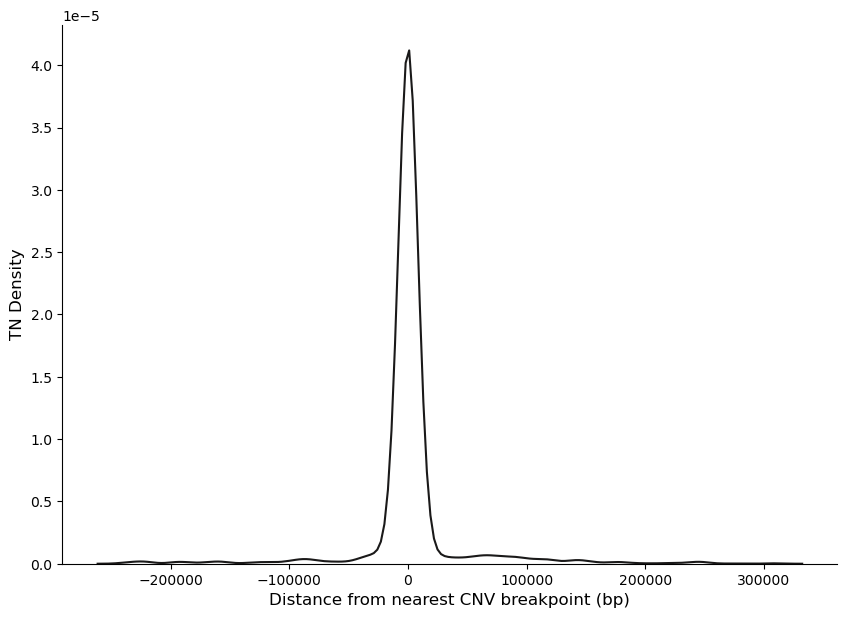

In [10]:
fig, ax = plt.subplots(1,figsize=(10,7))

g = sns.kdeplot(tx_distance.values(), ax=ax, color='#1a1919')
ax.set_xlabel('Distance from nearest CNV breakpoint (bp)', fontsize=12)
ax.set_ylabel('TN Density', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('../figures/fig3B.png', format='png', dpi=300)
plt.show()
